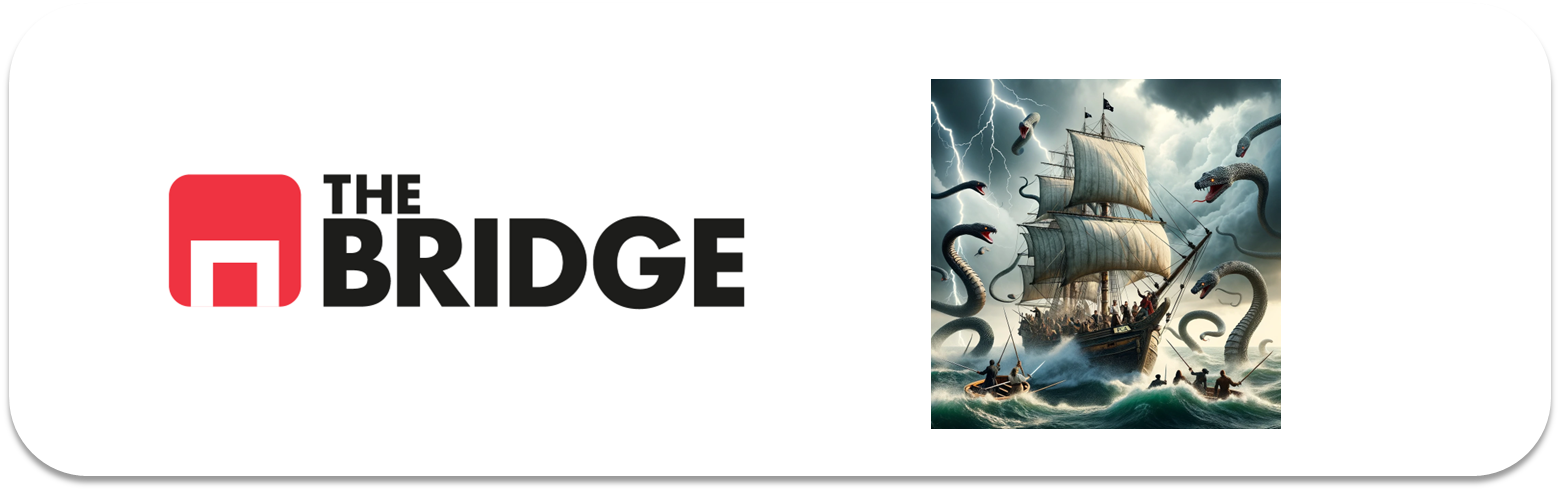

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [36]:
df = pd.read_csv("./data/credit_npo.csv")
df

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
12532,0,0.197116,59,0,0.290216,5140.0,6,0,1,0,0.0
12533,0,0.036726,62,0,0.884985,5833.0,12,0,1,0,0.0
12534,0,0.120313,49,0,0.577676,6333.0,7,0,2,0,2.0
12535,0,0.252566,63,0,0.037640,14000.0,9,0,0,0,1.0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [38]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [39]:
target = "SeriousDlqin2yrs"

In [40]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [41]:
bt.pinta_distribucion_categoricas(train_set, [target], True, True)

NameError: name 'bt' is not defined

In [42]:
train_set.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,9452.0,0.070144,0.255403,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,9452.0,0.335207,0.362233,0.0,0.034869,0.179211,0.587533,6.0
age,9452.0,51.491536,14.499298,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,9452.0,0.343314,2.930489,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,9452.0,0.486047,2.505031,0.0,0.146204,0.297564,0.477876,96.0
MonthlyIncome,9452.0,6868.428058,12580.543336,0.0,3466.000000,5441.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,9452.0,8.794647,5.139555,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,9452.0,0.180279,2.889984,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,9452.0,1.064325,1.148156,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,9452.0,0.152772,2.870119,0.0,0.000000,0.000000,0.000000,98.0


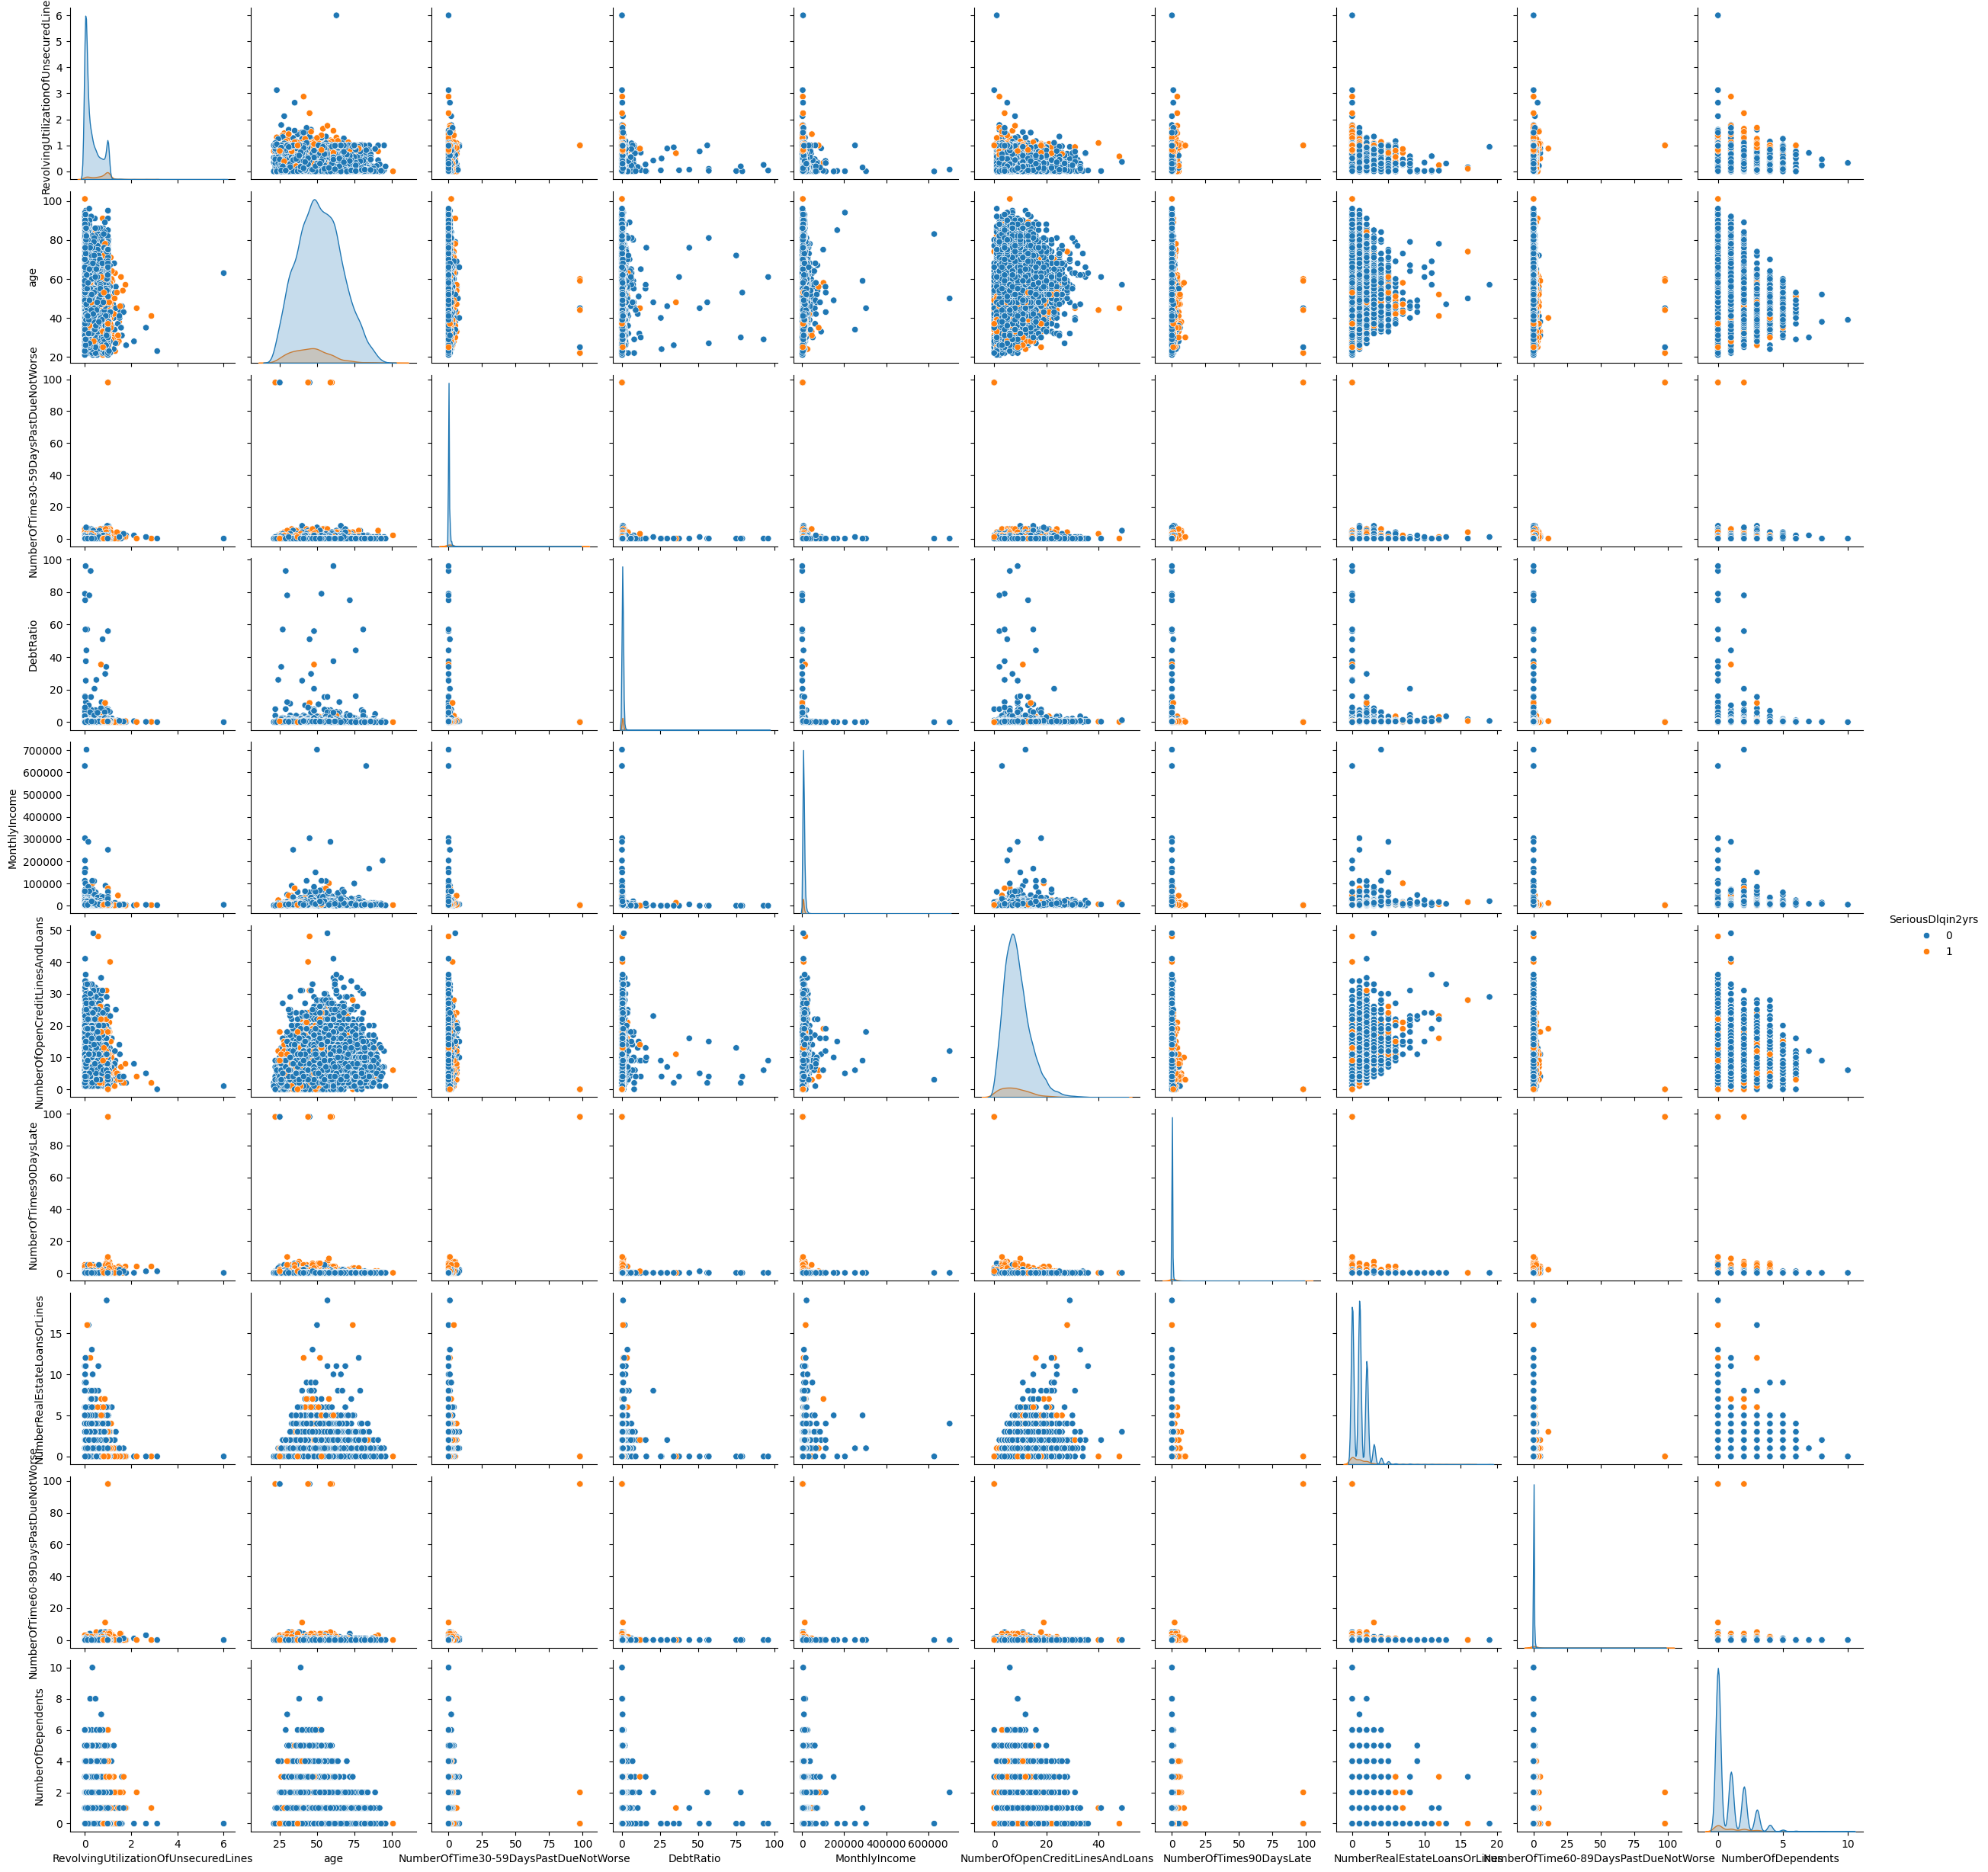

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train_set, hue=target, diag_kind="kde")
plt.show()

In [44]:
features_num = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfDependents"
]

In [45]:
# Análisis de la variable "NumberRealEstateLoansOrLines"
print("Analizamos con un poco más de detalle 'NumberRealEstateLoansOrLines' para decidir si es categórica o numérica:")

train_set["NumberRealEstateLoansOrLines"].value_counts()

Analizamos con un poco más de detalle 'NumberRealEstateLoansOrLines' para decidir si es categórica o numérica:


NumberRealEstateLoansOrLines
0     3356
1     3334
2     2095
3      413
4      137
5       67
6       19
8        8
7        8
11       3
9        3
12       3
16       2
10       2
13       1
19       1
Name: count, dtype: int64

In [46]:
	
features_num.append("NumberRealEstateLoansOrLines")

In [47]:
train_set["NumberOfTime30-59DaysPastDueNotWorse"].value_counts(True)

NumberOfTime30-59DaysPastDueNotWorse
0     0.831147
1     0.113521
2     0.033644
3     0.010897
4     0.005607
5     0.002116
6     0.001904
98    0.000846
8     0.000212
7     0.000106
Name: proportion, dtype: float64

In [48]:
n_corto = "NumberOfTime30-59DaysPastDueNotWorse"
train_set[train_set[target] == 1][n_corto].value_counts(True)

NumberOfTime30-59DaysPastDueNotWorse
0     0.502262
1     0.251885
2     0.123680
3     0.051282
4     0.034691
5     0.015083
6     0.013575
98    0.007541
Name: proportion, dtype: float64

In [49]:
n_corto = "NumberOfTime30-59DaysPastDueNotWorse"

# Método 1, con pd.cut
labels = [0, 1, 2]  # Cambio

train_set["N30-59"] = pd.cut(train_set[n_corto], bins=[-1, 0, 1, 10000], labels=labels, right=True).astype(int)
test_set["N30-59"] = pd.cut(test_set[n_corto], bins=[-1, 0, 1, 10000], labels=labels, right=True).astype(int)

train_set["N30-59"].value_counts(True)

N30-59
0    0.831147
1    0.113521
2    0.055332
Name: proportion, dtype: float64

In [50]:
train_set[train_set[target] == 1]["N30-59"].value_counts(True)

N30-59
0    0.502262
1    0.251885
2    0.245852
Name: proportion, dtype: float64

In [51]:
train_set["NumberOfTime60-89DaysPastDueNotWorse"].value_counts(True)

NumberOfTime60-89DaysPastDueNotWorse
0     0.947207
1     0.040521
2     0.008041
3     0.001481
4     0.001375
98    0.000846
5     0.000423
11    0.000106
Name: proportion, dtype: float64

In [52]:
(train_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int).value_counts()

NumberOfTime60-89DaysPastDueNotWorse
0    8953
1     499
Name: count, dtype: int64

In [53]:
train_set["N60-89"] = (train_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
test_set["N60-89"] = (test_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
train_set["N60-89"].value_counts(True)

N60-89
0    0.947207
1    0.052793
Name: proportion, dtype: float64

In [54]:
train_set[train_set[target] == 1]["N60-89"].value_counts(True)

N60-89
0    0.746606
1    0.253394
Name: proportion, dtype: float64

In [55]:
train_set[train_set[target] == 0]["N60-89"].value_counts(True)

N60-89
0    0.962339
1    0.037661
Name: proportion, dtype: float64

In [56]:
train_set["NumberOfTimes90DaysLate"].value_counts(True)

NumberOfTimes90DaysLate
0     0.943610
1     0.033115
2     0.012590
3     0.004655
4     0.002751
5     0.001481
98    0.000846
6     0.000529
7     0.000212
9     0.000106
10    0.000106
Name: proportion, dtype: float64

In [57]:
# Dos categorías: 0 y uno o más
train_set["N90"] = (train_set["NumberOfTimes90DaysLate"] > 0).astype(int)
test_set["N90"] = (test_set["NumberOfTimes90DaysLate"] > 0).astype(int)
train_set["N90"].value_counts(True)

N90
0    0.94361
1    0.05639
Name: proportion, dtype: float64

In [58]:
train_set[train_set[target] == 1]["N90"].value_counts(True)

N90
0    0.642534
1    0.357466
Name: proportion, dtype: float64

In [59]:
features_cat = ["N30-59", "N60-89", "N90"]

In [60]:
features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines']

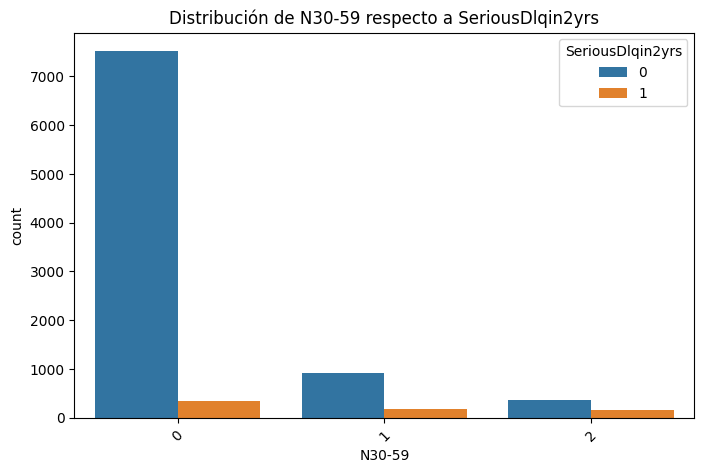

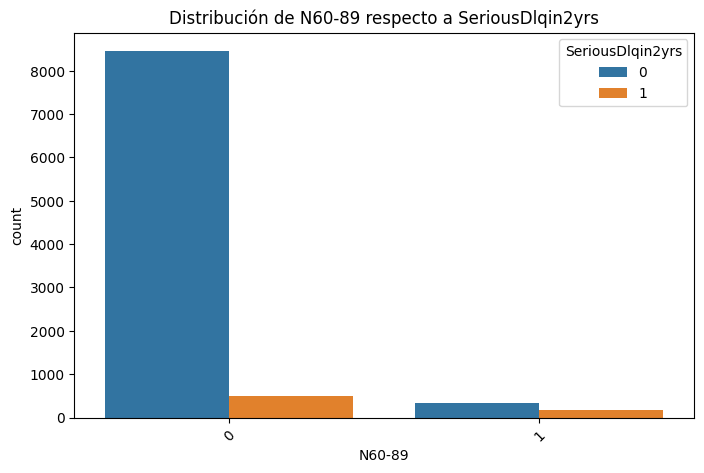

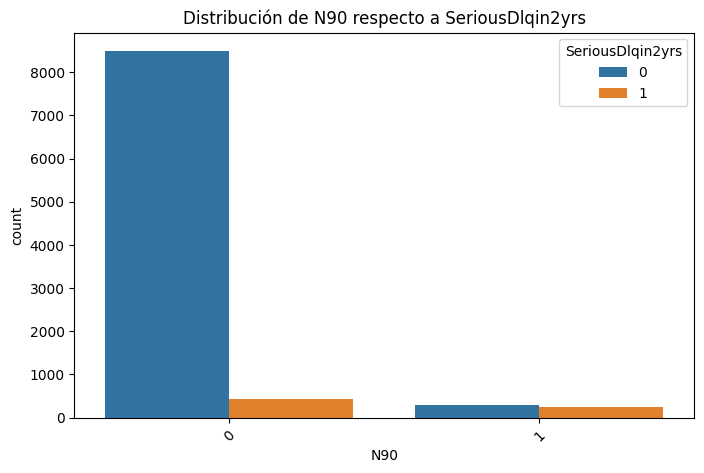

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features_cat:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_set, x=col, hue=target)
    plt.title(f"Distribución de {col} respecto a {target}")
    plt.xticks(rotation=45)
    plt.show()

In [62]:
features_visual = features_cat.copy()

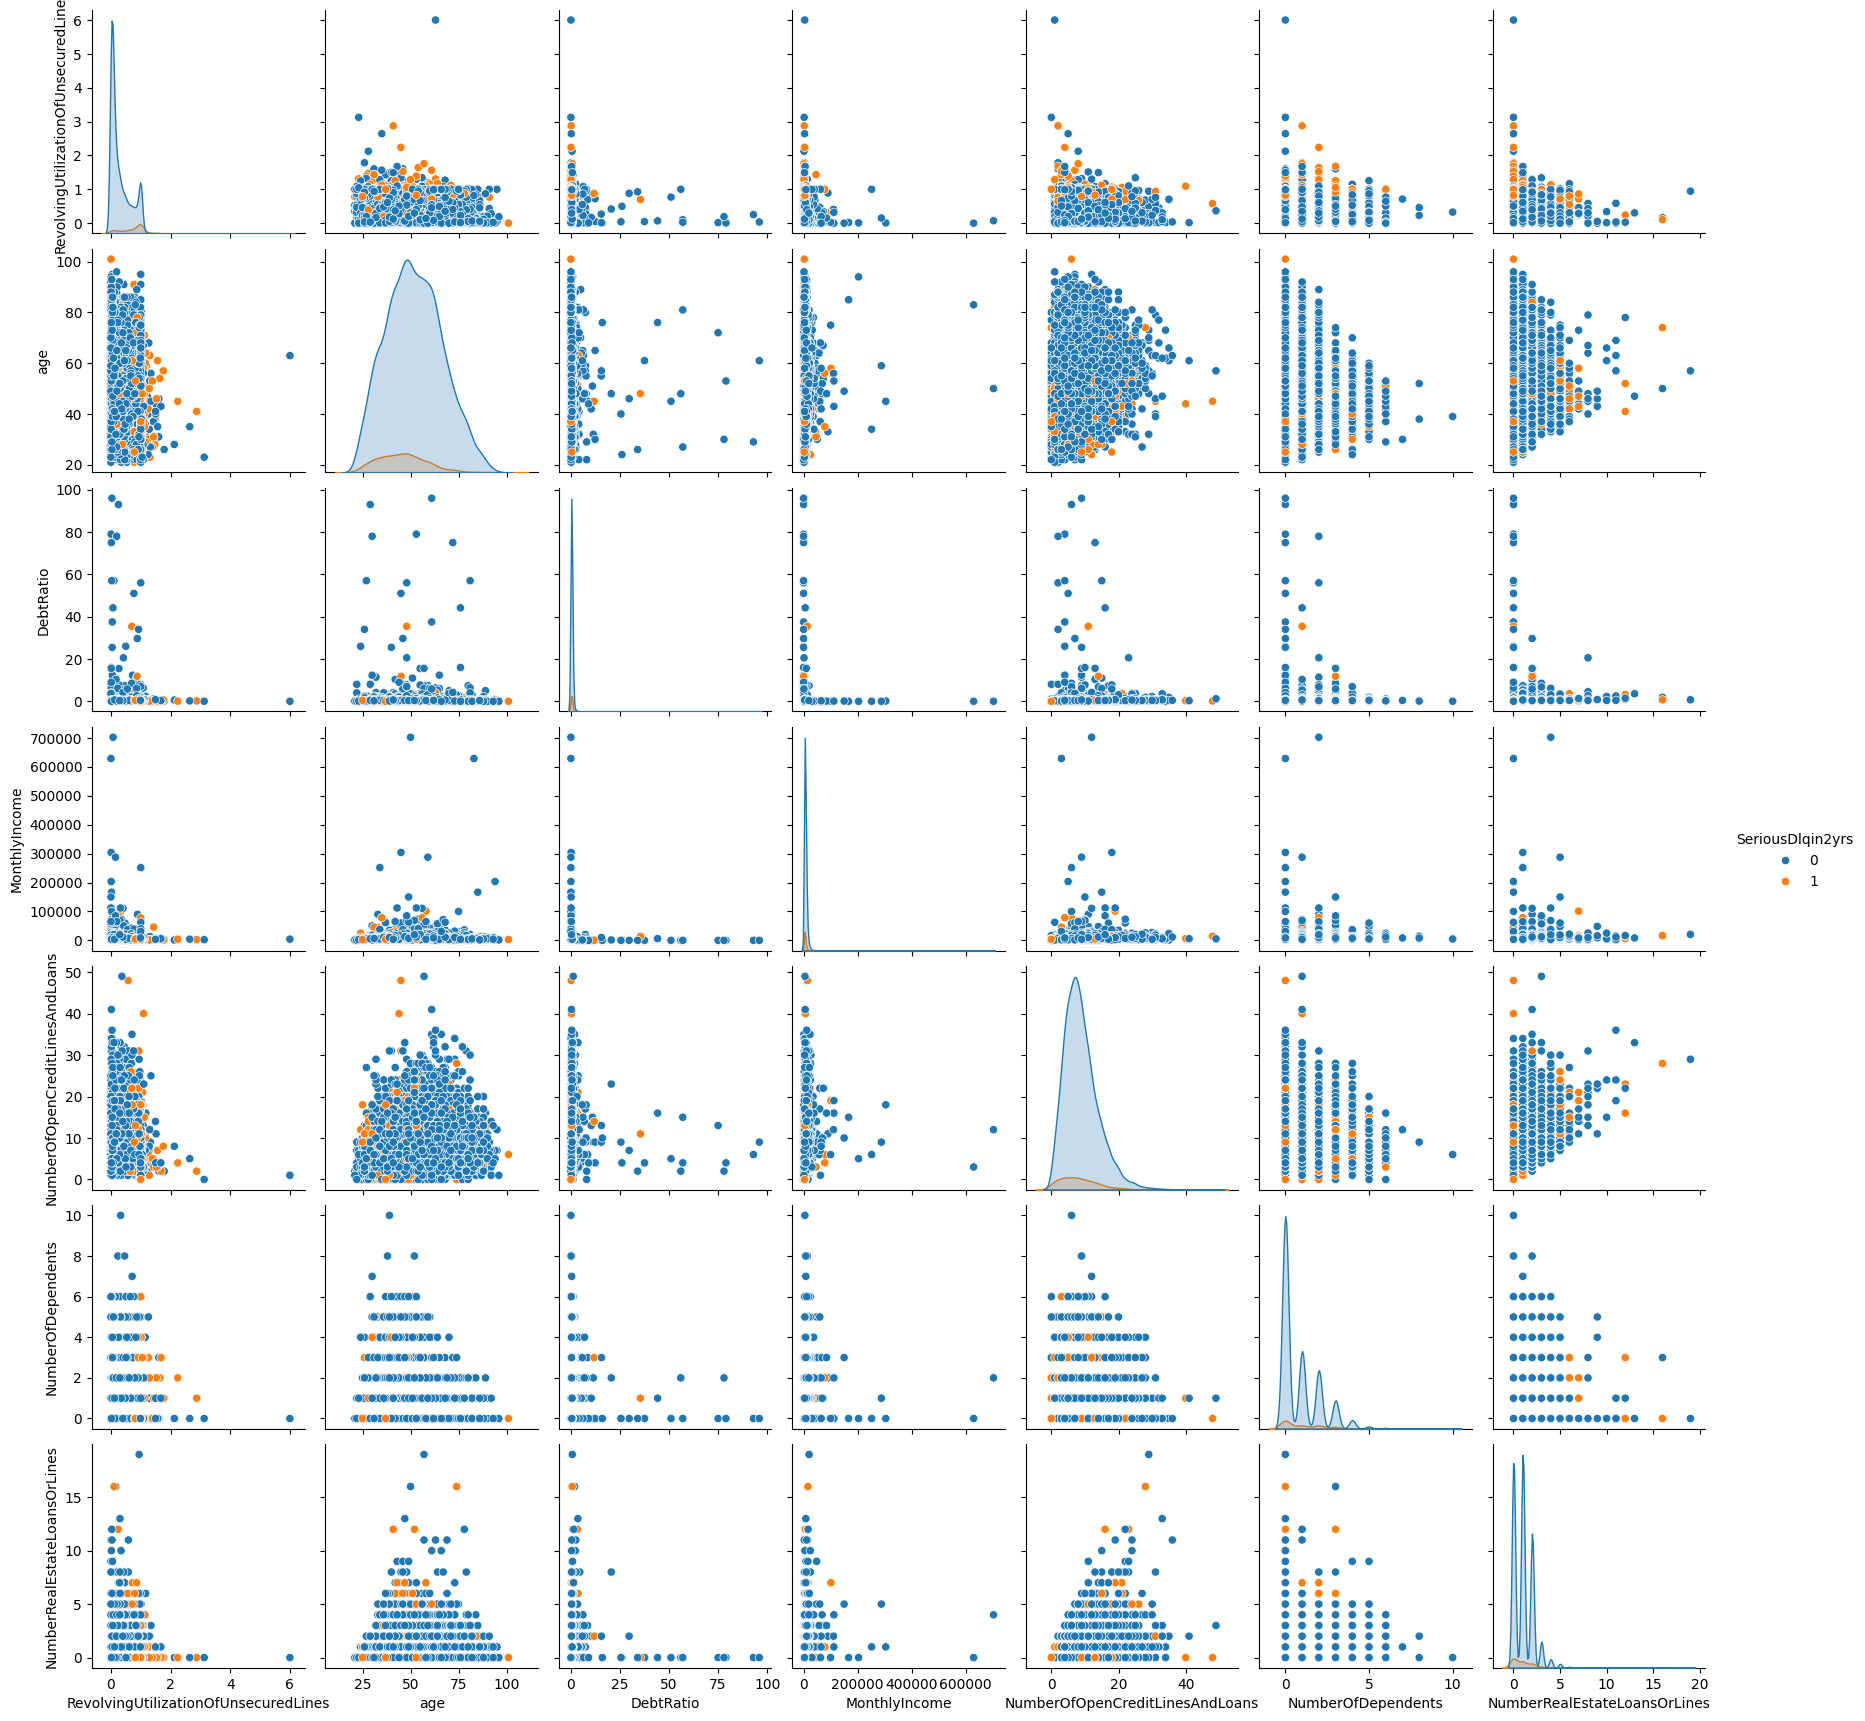

In [63]:
sns.pairplot(train_set[features_num + [target]], hue = target)

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


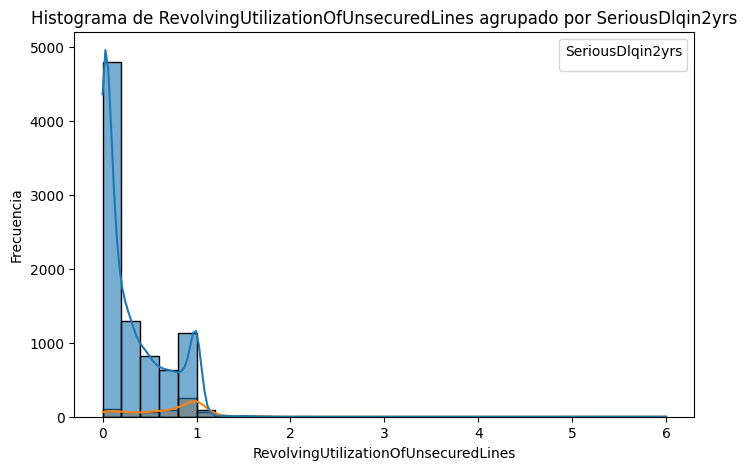

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


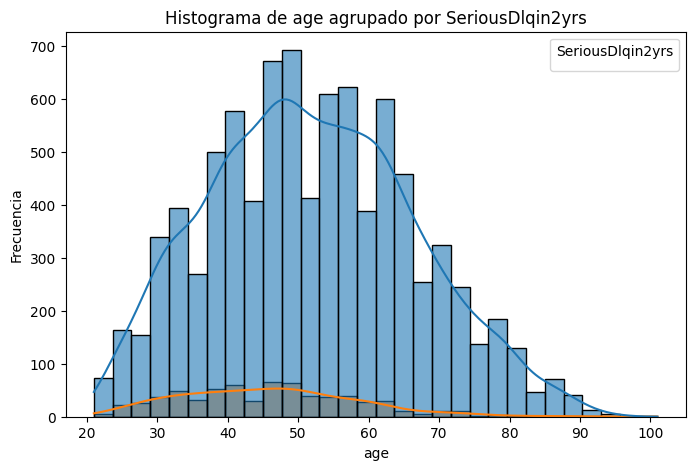

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


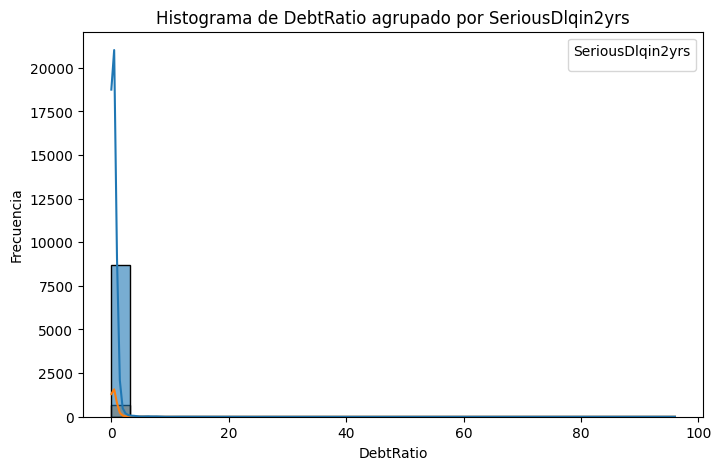

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


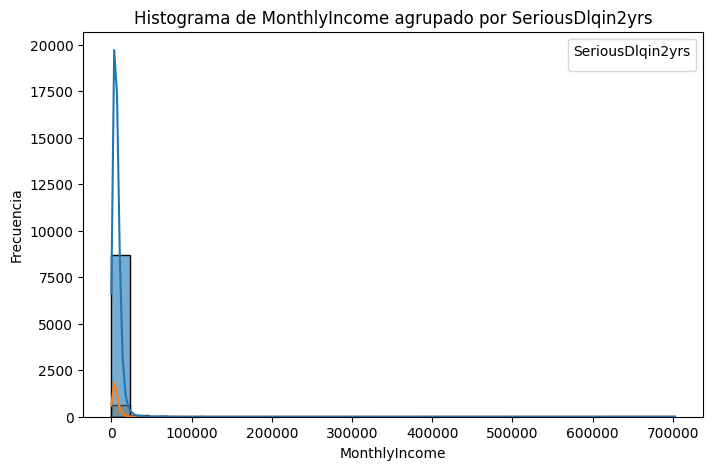

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


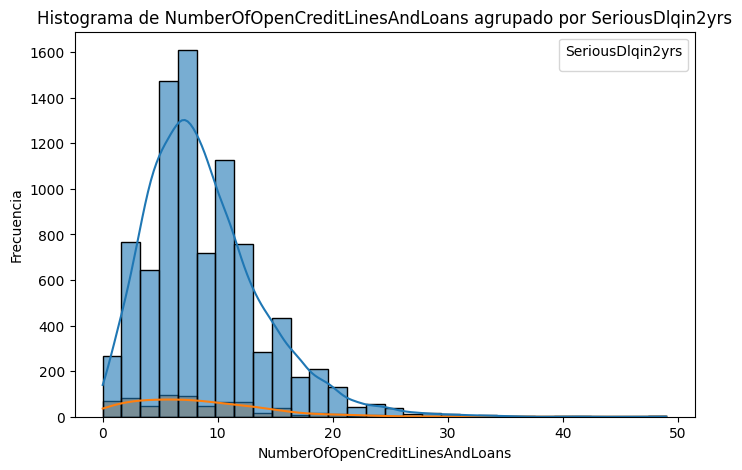

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


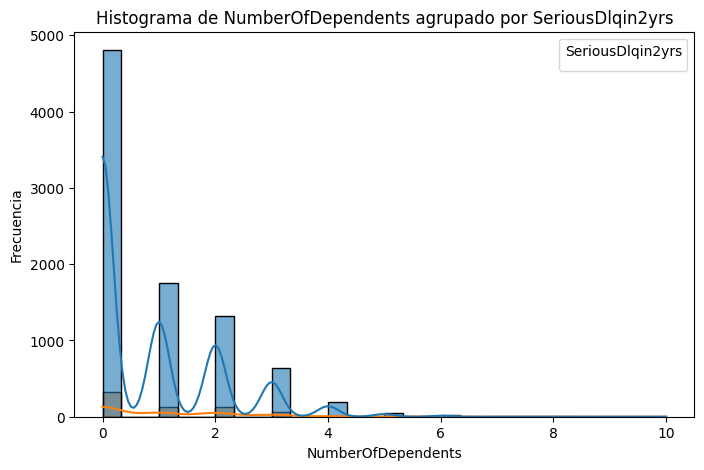

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/1197559851.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


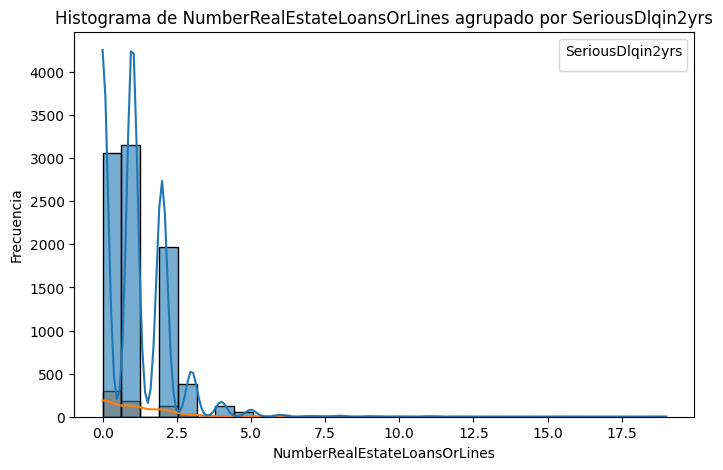

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features_num:
    plt.figure(figsize=(8, 5))
    sns.histplot(data=train_set, x=col, hue=target, kde=True, bins=30, alpha=0.6)
    plt.title(f"Histograma de {col} agrupado por {target}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.legend(title=target)
    plt.show()

In [65]:
features_visual.append("RevolvingUtilizationOfUnsecuredLines")

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/378513986.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


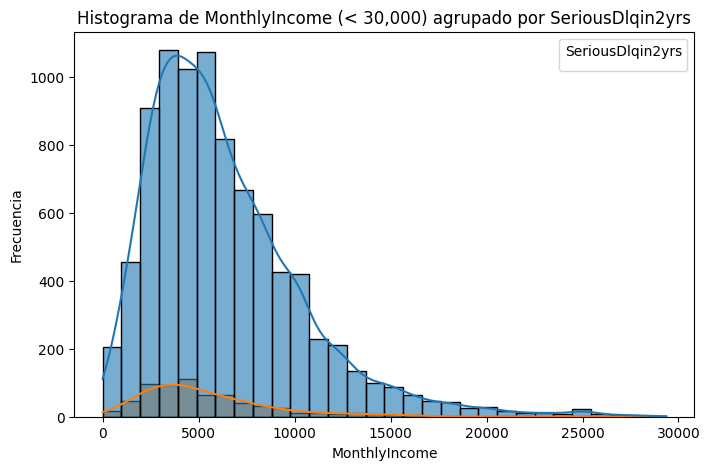

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los datos donde MonthlyIncome < 30,000
sin_monthlyincome_outliers = train_set[train_set["MonthlyIncome"] < 30000]

plt.figure(figsize=(8, 5))
sns.histplot(data=sin_monthlyincome_outliers, x="MonthlyIncome", hue=target, kde=True, bins=30, alpha=0.6)
plt.title(f"Histograma de MonthlyIncome (< 30,000) agrupado por {target}")
plt.xlabel("MonthlyIncome")
plt.ylabel("Frecuencia")
plt.legend(title=target)
plt.show()

In [68]:
cat_col = target
num_col = "MonthlyIncome"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 3309844.0
Valor p: 4.937655211085433e-09


In [69]:
train_set["DebtRatio"].value_counts()

DebtRatio
0.000000    186
1.000000      3
0.294341      2
0.003200      2
0.157461      2
           ... 
0.350887      1
0.069607      1
0.346664      1
0.165180      1
0.354829      1
Name: count, Length: 9194, dtype: int64

In [70]:
features_visual.append("MonthlyIncome")

In [71]:
train_set["DebtRatio"].describe()

count    9452.000000
mean        0.486047
std         2.505031
min         0.000000
25%         0.146204
50%         0.297564
75%         0.477876
max        96.000000
Name: DebtRatio, dtype: float64

/var/folders/xb/tnn5cnz546z_22tq9t1fbf1h0000gn/T/ipykernel_1087/2503996528.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=target)


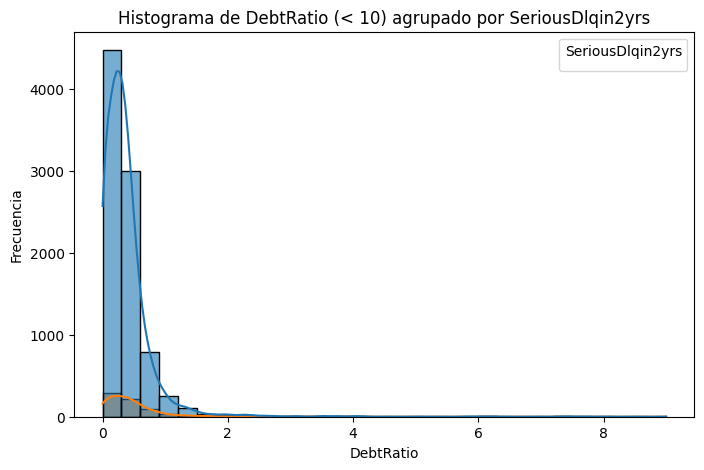

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filtrar los datos donde DebtRatio < 10
sin_debtratio_outliers = train_set[train_set["DebtRatio"] < 10]

plt.figure(figsize=(8, 5))
sns.histplot(data=sin_debtratio_outliers, x="DebtRatio", hue=target, kde=True, bins=30, alpha=0.6)
plt.title(f"Histograma de DebtRatio (< 10) agrupado por {target}")
plt.xlabel("DebtRatio")
plt.ylabel("Frecuencia")
plt.legend(title=target)
plt.show()

In [76]:
cat_col = target
num_col = "DebtRatio"

grupo_a = train_set.loc[train_set[cat_col] == 0][num_col]
grupo_b = train_set.loc[train_set[cat_col] == 1][num_col]

u_stat, p_valor = mannwhitneyu(grupo_a, grupo_b)

print("Estadístico U:", u_stat)
print("Valor p:", p_valor)

Estadístico U: 2623985.5
Valor p: 1.9202882288986672e-05


In [77]:
features_visual.append("DebtRatio")

In [78]:
features_visual

['N30-59',
 'N60-89',
 'N90',
 'RevolvingUtilizationOfUnsecuredLines',
 'MonthlyIncome',
 'DebtRatio']

In [79]:
for umbral_varianza in np.arange(0, 1, 0.1):
    print(f"Para umbral = {umbral_varianza}")
    var_selector = VarianceThreshold(umbral_varianza)
    var_selector.fit(train_set[features_visual])
    print("Lista seleccionada para selector de Varianza", var_selector.get_feature_names_out())

Para umbral = 0.0
Lista seleccionada para selector de Varianza ['N30-59' 'N60-89' 'N90' 'RevolvingUtilizationOfUnsecuredLines'
 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.1
Lista seleccionada para selector de Varianza ['N30-59' 'RevolvingUtilizationOfUnsecuredLines' 'MonthlyIncome'
 'DebtRatio']
Para umbral = 0.2
Lista seleccionada para selector de Varianza ['N30-59' 'MonthlyIncome' 'DebtRatio']
Para umbral = 0.30000000000000004
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRatio']
Para umbral = 0.4
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRatio']
Para umbral = 0.5
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRatio']
Para umbral = 0.6000000000000001
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRatio']
Para umbral = 0.7000000000000001
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRatio']
Para umbral = 0.8
Lista seleccionada para selector de Varianza ['MonthlyIncome' 'DebtRat

In [80]:

features_num

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'NumberRealEstateLoansOrLines']

In [81]:
# features_num.remove("quality") 

X_train = train_set[features_num]
y_train = train_set[target]

selector = SelectKBest(f_classif, k=4)

x_data_kbest = selector.fit_transform(X_train, y_train)

X_train_kbest = pd.DataFrame(x_data_kbest, columns=selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
0,0.391240,68.0,13.0,0.0
1,0.906540,59.0,7.0,1.0
2,0.933223,52.0,3.0,3.0
3,0.857859,50.0,9.0,0.0
4,0.000000,61.0,5.0,1.0
...,...,...,...,...
9447,0.397822,53.0,14.0,0.0
9448,0.015171,76.0,4.0,0.0
9449,0.988201,62.0,4.0,0.0
9450,0.122072,41.0,9.0,1.0


In [83]:
features_filter = list(selector.get_feature_names_out())

In [84]:
features_filter

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents']

In [85]:
features_cat

['N30-59', 'N60-89', 'N90']

In [86]:
for col in features_cat:
    print(f"MI{col};{target})", mutual_info_score(train_set[col],train_set[target]))

MIN30-59;SeriousDlqin2yrs) 0.024765507782367968
MIN60-89;SeriousDlqin2yrs) 0.017771329855032478
MIN90;SeriousDlqin2yrs) 0.03421467132247159


In [87]:
features_filter += features_cat

In [88]:
mi = {}
for col in features_cat:
    mi[col] = mutual_info_score(train_set[col],train_set[target])
    print(f"MI{col};{target}):", mi[col])
pd.Series(mi)/sum(mi.values())

MIN30-59;SeriousDlqin2yrs): 0.024765507782367968
MIN60-89;SeriousDlqin2yrs): 0.017771329855032478
MIN90;SeriousDlqin2yrs): 0.03421467132247159


N30-59    0.322671
N60-89    0.231544
N90       0.445785
dtype: float64

In [89]:
features_filter

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents',
 'N30-59',
 'N60-89',
 'N90']

In [90]:
features = features_num + features_cat
rf_selector = RandomForestClassifier(random_state=42, class_weight="balanced")
selector_modelo = SelectFromModel(estimator=rf_selector, threshold="median")  # Nos quedamos con la mitad
selector_modelo.fit(train_set[features], train_set[target])  # X_train e y_train en los argumentos
features_modelo = list(selector_modelo.get_feature_names_out())
features_modelo

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'N30-59']

In [91]:
rf_check = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_check.fit(train_set[features], train_set[target])

df_importance = pd.DataFrame(
    rf_check.feature_importances_, columns=["importance"], index=features
)

df_importance.sort_values("importance", ascending=False)

,importance
RevolvingUtilizationOfUnsecuredLines,0.277984
DebtRatio,0.131388
MonthlyIncome,0.117531
age,0.115331
N30-59,0.086444
NumberOfOpenCreditLinesAndLoans,0.084459
N90,0.082428
NumberOfDependents,0.035072
NumberRealEstateLoansOrLines,0.034747
N60-89,0.034615


In [92]:
df_importance[df_importance.importance > df_importance.importance.median()]

,importance
RevolvingUtilizationOfUnsecuredLines,0.277984
age,0.115331
DebtRatio,0.131388
MonthlyIncome,0.117531
N30-59,0.086444


### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.